## DUSP1 Dataframe Concatenation and Replica Check
- Concatenate experimental dataframes based on specific conditions:
    - **100nM 3hr Time-Sweep (TS):** Data collected over a 3-hour time period with a fixed concentration of 100nM.
    - **75min Concentration-Sweep:** Data collected over varying concentrations during a 75-minute time period.
    - **3hr Time-Concentration Sweep (TCS):** Data collected over a 3-hour period with varying concentrations.
    - **Triptiolide (TPL):** Data collected under conditions involving Triptiolide treatment.
- Perform a replica check to ensure data consistency and identify any discrepancies across experimental replicates.
- Document and visualize the concatenated data for further analysis.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import datetime

import h5py
import dask.array as da

# src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(src_path)
# sys.path.append(src_path)

# from src.Analysis_DUSP1_v2 import DUSP1DisplayManager

## DUSP1 Experiments

In [2]:
# Define your directory
df_directory = '/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification'

# Initialize containers
spots_total = []
clusters_total = []
cellprops_total = []
cellresults_total = []

# List all files
all_files = os.listdir(df_directory)

# Sort files into categories
for file in all_files:
    filepath = os.path.join(df_directory, file)
    
    if file.endswith('merged_spots_df_MG3_Abs4_Apr24.csv'):
        spots_total.append(pd.read_csv(filepath))
    elif file.endswith('merged_clusters_df_MG3_Abs4_Apr24.csv'):
        clusters_total.append(pd.read_csv(filepath))
    elif file.endswith('merged_cellprops_df_MG3_Abs4_Apr24.csv'):
        cellprops_total.append(pd.read_csv(filepath))
    elif file.endswith('cell_level_results_MG3_Abs4_Apr24.csv'):
        cellresults_total.append(pd.read_csv(filepath))

# Concatenate into single DataFrames
spots_total = pd.concat(spots_total, ignore_index=True)
clusters_total = pd.concat(clusters_total, ignore_index=True)
cellprops_total = pd.concat(cellprops_total, ignore_index=True)
cellresults_total = pd.concat(cellresults_total, ignore_index=True)

In [3]:
# Make a copy of the DUSP1 data
DUSP1_data = cellresults_total.copy()

# Experiment 1: 100 nM Dex time sweep with 12 timepoints
df_expt1 = DUSP1_data[DUSP1_data['replica'].isin(['D', 'E', 'F', 'M', 'N'])]
expt1_timepoints = [10, 20, 30, 40, 50, 60, 75, 90, 120, 150, 180]
expt1_concs = [100]

# Experiment 2: 75min concentration sweep with 6 concentrations
df_expt2 = DUSP1_data[DUSP1_data['replica'].isin(['G', 'H', 'I'])]
expt2_timepoints = [75]
expt2_concs = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Experiment 3: 0.3, 1, 10nM Dex time sweep with 6 timepoints
df_expt3 = DUSP1_data[DUSP1_data['replica'].isin(['J', 'K', 'L'])]
expt3_timepoints = [30, 50, 75, 90, 120, 180]
expt3_concs = [0.3, 1, 10]

# Calculate means for each replica
replica_means = DUSP1_data.groupby(['dex_conc', 'time', 'replica']).agg({
    'nuc_MG_count': 'mean',
    'cyto_MG_count': 'mean',
    'MG_count': 'mean',
}).reset_index()

# Calculate the mean and standard deviation of the replica means
summary_stats = replica_means.groupby(['dex_conc', 'time']).agg({
    'nuc_MG_count': ['mean', 'std'],
    'cyto_MG_count': ['mean', 'std'],
    'MG_count': ['mean', 'std'],
}).reset_index()

# Rename columns for easier access
summary_stats.columns = [
    'dex_conc', 'time',
    'mean_nuc_count', 'std_nuc_count',
    'mean_cyto_count', 'std_cyto_count',
    'mean_MG_count', 'std_MG_count'
]

# Calculate overall mean and standard deviation for each concentration and time point
overall_stats = DUSP1_data.groupby(['dex_conc', 'time']).agg({
    'nuc_MG_count': ['mean', 'std'],
    'cyto_MG_count': ['mean', 'std'],
    'MG_count': ['mean', 'std'],
}).reset_index()

# Rename columns for easier access
overall_stats.columns = [
    'dex_conc', 'time',
    'overall_mean_nuc', 'overall_std_nuc',
    'overall_mean_cyto', 'overall_std_cyto',
    'overall_mean_MG', 'overall_std_MG'
]

# Extract 0 min data (shared baseline from dex_conc == 0)
zero_min_summary = summary_stats[summary_stats['time'] == 0]
zero_min_overall = overall_stats[overall_stats['time'] == 0]

# Set Style
sns.set_theme(style="ticks", palette="colorblind", context="poster", font='times new roman')

# Define the color palette for Nuclear and Cytoplasmic intensities
colors_nuc_cyto = sns.color_palette("colorblind", 2)  # Two colors: one for Nuclear, one for Cytoplasmic

# # Loop through the three experiments
# experiments = {
#     "Experiment 1: 100 nM Time Sweep": (expt1_concs, expt1_timepoints),
#     # "Experiment 2: 75 min Concentration Sweep": (expt2_concs, expt2_timepoints),
#     "Experiment 3: 0.3, 1, 10 nM Time Sweep": (expt3_concs, expt3_timepoints)
# }

# for expt_name, (concs, timepoints) in experiments.items():
#     for conc in concs:
#         # Filter data for plotting
#         subset_summary = summary_stats[(summary_stats['dex_conc'] == conc) & (summary_stats['time'].isin(timepoints))]
#         subset_overall = overall_stats[(overall_stats['dex_conc'] == conc) & (overall_stats['time'].isin(timepoints))]

#         # Add 0 min time point to all subsets if not already present
#         if 0 not in subset_summary['time'].values:
#             subset_summary = pd.concat([zero_min_summary, subset_summary], ignore_index=True)
#         if 0 not in subset_overall['time'].values:
#             subset_overall = pd.concat([zero_min_overall, subset_overall], ignore_index=True)

#         plt.figure(figsize=(10, 5))

#         # Plot Nuclear mRNA Count Mean with Error Bars
#         plt.errorbar(subset_summary['time'], subset_summary['mean_nuc_count'],
#                      yerr=subset_summary['std_nuc_count'], fmt='-o', color=colors_nuc_cyto[0], capsize=5,
#                      label='Nuclear mRNA Count Replicas')

#         # Filling between std deviations for overall data - Nuclear
#         plt.fill_between(subset_overall['time'],
#                          subset_overall['overall_mean_nuc'] - subset_overall['overall_std_nuc'],
#                          subset_overall['overall_mean_nuc'] + subset_overall['overall_std_nuc'],
#                          color=colors_nuc_cyto[0], alpha=0.2, label='Total Data Spread - Nuclear')

#         # Plot Cytoplasmic mRNA Count Mean with Error Bars
#         plt.errorbar(subset_summary['time'], subset_summary['mean_cyto_count'],
#                      yerr=subset_summary['std_cyto_count'], fmt='-o', color=colors_nuc_cyto[1], capsize=5,
#                      label='Cytoplasmic mRNA Count Replicas')

#         # Filling between std deviations for overall data - Cytoplasmic
#         plt.fill_between(subset_overall['time'],
#                          subset_overall['overall_mean_cyto'] - subset_overall['overall_std_cyto'],
#                          subset_overall['overall_mean_cyto'] + subset_overall['overall_std_cyto'],
#                          color=colors_nuc_cyto[1], alpha=0.2, label='Total Data Spread - Cytoplasmic')
        
#         # Plot the total mRNA Count Mean with Error Bars
#         plt.errorbar(subset_summary['time'], subset_summary['mean_MG_count'],
#                     yerr=subset_summary['std_MG_count'], fmt='-o', color='black', capsize=5,
#                     label='Total mRNA Count Replicas')
#         # Filling between std deviations for overall data - Total
# # After
#         plt.fill_between(subset_overall['time'],
#                         subset_overall['overall_mean_MG'] - subset_overall['overall_std_MG'],
#                         subset_overall['overall_mean_MG'] + subset_overall['overall_std_MG'],
#                         color='black', alpha=0.2, label='Total Data Spread - Total')
#         # Set x-ticks to be the time points
#         plt.xticks(subset_summary['time'], rotation=45)

#         # Customize the plot
#         plt.title(f"{expt_name} - {conc} nM Dex", fontsize=18, fontweight='bold')
#         plt.xlabel('Time (min)', fontsize=14)
#         plt.ylabel('mRNA Spot Count', fontsize=14)
#         plt.grid(True)
#         plt.legend(loc='upper left', fontsize=12, frameon=False, bbox_to_anchor=(1, 1))


#         # Show the plot
#         plt.show()


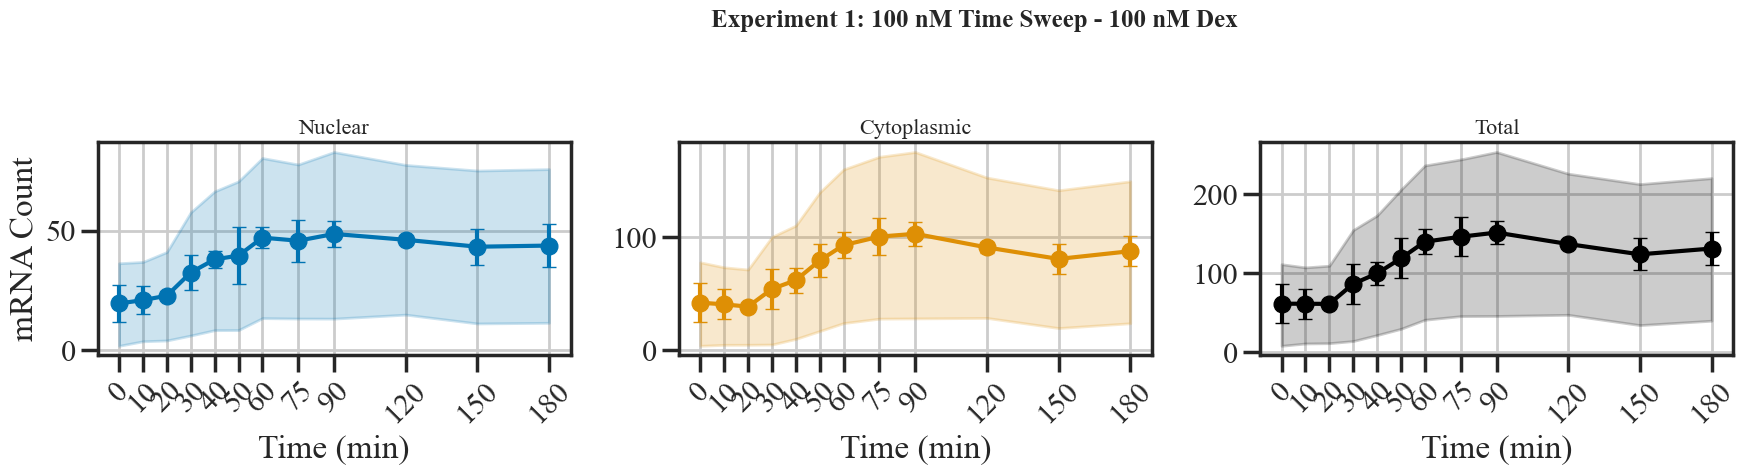

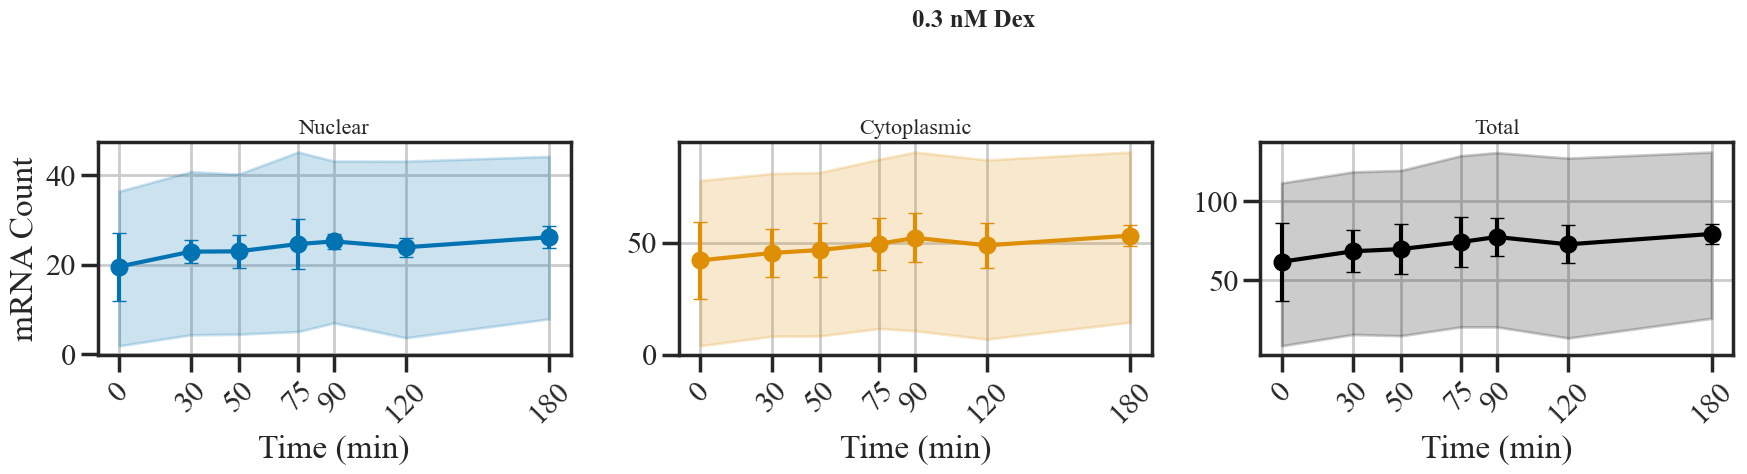

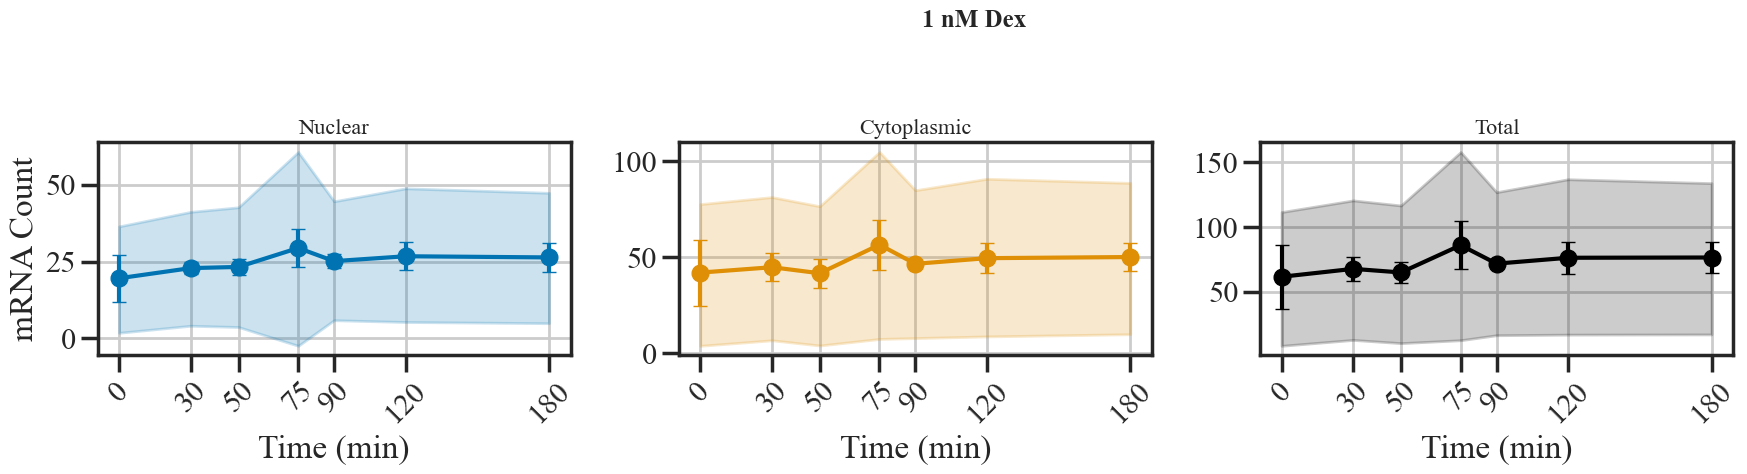

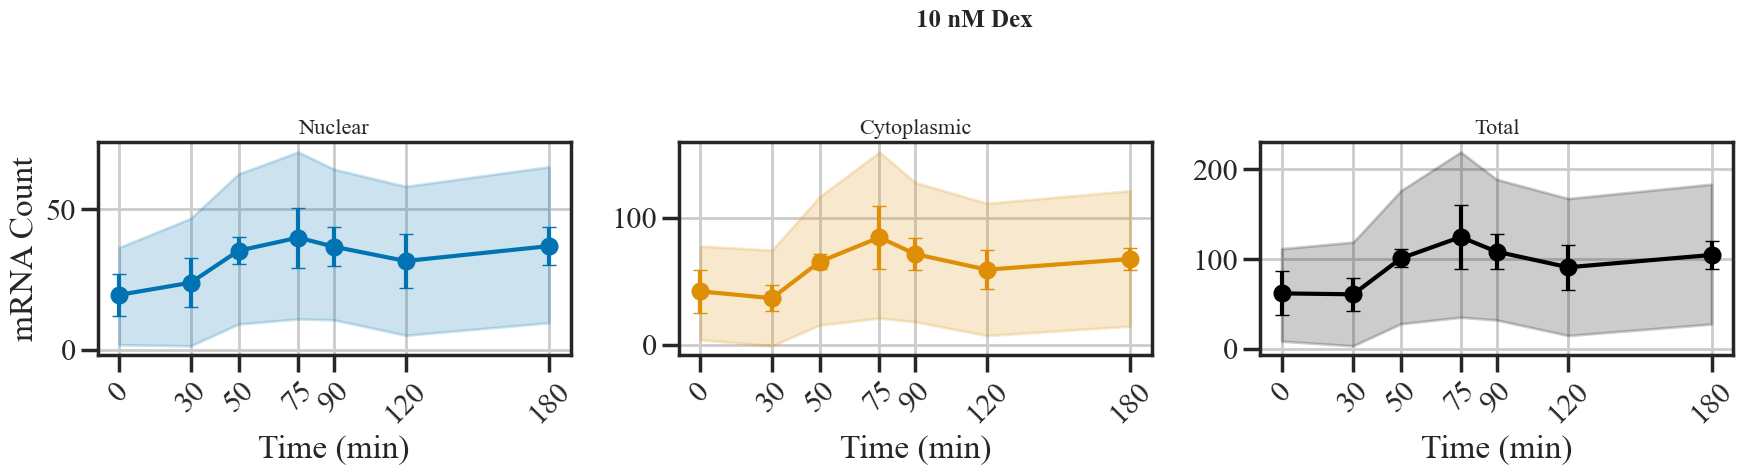

In [11]:
# Loop through the three experiments
experiments = {
    "Experiment 1: 100 nM Time Sweep": (expt1_concs, expt1_timepoints),
    # "Experiment 2: 75 min Concentration Sweep": (expt2_concs, expt2_timepoints),
    "Experiment 3: 0.3, 1, 10 nM Time Sweep": (expt3_concs, expt3_timepoints)
}

for expt_name, (concs, timepoints) in experiments.items():
    for conc in concs:
        # Filter data for plotting
        subset_summary = summary_stats[(summary_stats['dex_conc'] == conc) & (summary_stats['time'].isin(timepoints))]
        subset_overall = overall_stats[(overall_stats['dex_conc'] == conc) & (overall_stats['time'].isin(timepoints))]

        # Add 0 min time point to all subsets if not already present
        if 0 not in subset_summary['time'].values:
            subset_summary = pd.concat([zero_min_summary, subset_summary], ignore_index=True)
        if 0 not in subset_overall['time'].values:
            subset_overall = pd.concat([zero_min_overall, subset_overall], ignore_index=True)

        # Create figure with three horizontal subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

        # Plot configs
        titles = ['Nuclear', 'Cytoplasmic', 'Total']
        colors = [colors_nuc_cyto[0], colors_nuc_cyto[1], 'black']
        means = ['mean_nuc_count', 'mean_cyto_count', 'mean_MG_count']
        stds = ['std_nuc_count', 'std_cyto_count', 'std_MG_count']
        overall_means = ['overall_mean_nuc', 'overall_mean_cyto', 'overall_mean_MG']
        overall_stds = ['overall_std_nuc', 'overall_std_cyto', 'overall_std_MG']
        labels = ['Nuclear mRNA Count Replicas', 'Cytoplasmic mRNA Count Replicas', 'Total mRNA Count Replicas']

        for i, ax in enumerate(axes):
            # Plot mean with error bars
            ax.errorbar(subset_summary['time'], subset_summary[means[i]],
                        yerr=subset_summary[stds[i]], fmt='-o', color=colors[i], capsize=5,
                        label=labels[i])

            # Plot shaded region (overall mean ± std)
            ax.fill_between(subset_overall['time'],
                            subset_overall[overall_means[i]] - subset_overall[overall_stds[i]],
                            subset_overall[overall_means[i]] + subset_overall[overall_stds[i]],
                            color=colors[i], alpha=0.2)

            ax.set_title(titles[i], fontsize=16)
            ax.set_xlabel('Time (min)')
            ax.grid(True)
            ax.set_xticks(subset_summary['time'])
            ax.tick_params(axis='x', rotation=45)

            if i == 0:
                ax.set_ylabel('mRNA Count')

        # # Put a **single legend** outside to the right
        # handles, labels = axes[0].get_legend_handles_labels()
        # fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, fontsize=12)

        # Adjust title:
        if "Experiment 3" in expt_name:
            fig.suptitle(f"{conc} nM Dex", fontsize=18, fontweight='bold')
        else:
            fig.suptitle(f"{expt_name} - {conc} nM Dex", fontsize=18, fontweight='bold')

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for suptitle and legend
        plt.show()

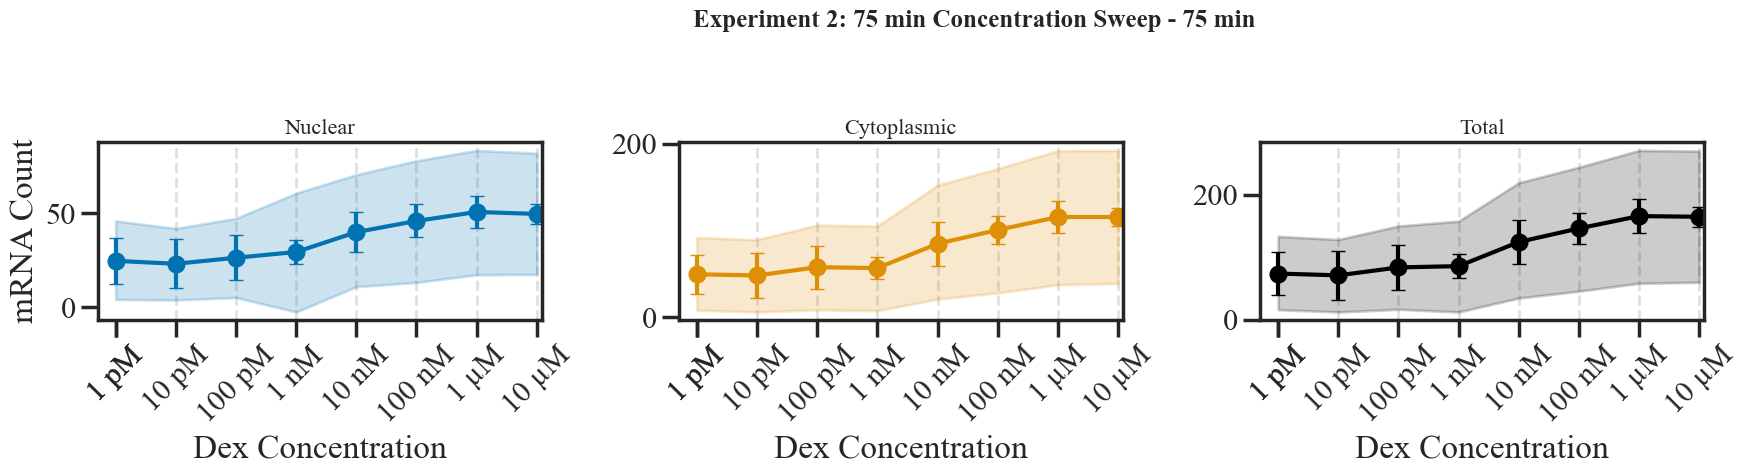

In [13]:
import matplotlib.ticker as ticker
import numpy as np

# Now handling Experiment 2 separately
expt2_name = "Experiment 2: 75 min Concentration Sweep"
concs = expt2_concs
timepoints = expt2_timepoints

# Set a small value for 0 concentration
zero_conc_value = 1e-3  # small fake value to represent 0 on log axis

for timepoint in timepoints:
    # Full subset including 0 nM
    subset_summary = summary_stats[(summary_stats['time'] == timepoint) & (summary_stats['dex_conc'].isin(concs))]
    subset_overall = overall_stats[(overall_stats['time'] == timepoint) & (overall_stats['dex_conc'].isin(concs))]

    # Modify 0 nM entries
    subset_summary = subset_summary.copy()
    subset_overall = subset_overall.copy()
    subset_summary.loc[subset_summary['dex_conc'] == 0, 'dex_conc'] = zero_conc_value
    subset_overall.loc[subset_overall['dex_conc'] == 0, 'dex_conc'] = zero_conc_value

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

    # Plot configs
    titles = ['Nuclear', 'Cytoplasmic', 'Total']
    colors = [colors_nuc_cyto[0], colors_nuc_cyto[1], 'black']
    means = ['mean_nuc_count', 'mean_cyto_count', 'mean_MG_count']
    stds = ['std_nuc_count', 'std_cyto_count', 'std_MG_count']
    overall_means = ['overall_mean_nuc', 'overall_mean_cyto', 'overall_mean_MG']
    overall_stds = ['overall_std_nuc', 'overall_std_cyto', 'overall_std_MG']
    labels = ['Nuclear mRNA Count Replicas', 'Cytoplasmic mRNA Count Replicas', 'Total mRNA Count Replicas']

    # All tested concentrations (after replacing 0)
    all_concs_for_ticks = [zero_conc_value, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

    # Define the matching labels
    tick_labels = ['0', '1 pM', '10 pM', '100 pM', '1 nM', '10 nM', '100 nM', '1 µM', '10 µM']

    for i, ax in enumerate(axes):
        # Plot mean with error bars
        ax.errorbar(subset_summary['dex_conc'], subset_summary[means[i]],
                    yerr=subset_summary[stds[i]], fmt='-o', color=colors[i], capsize=5,
                    label=labels[i])

        # Shaded region
        ax.fill_between(subset_overall['dex_conc'],
                        subset_overall[overall_means[i]] - subset_overall[overall_stds[i]],
                        subset_overall[overall_means[i]] + subset_overall[overall_stds[i]],
                        color=colors[i], alpha=0.2)

        ax.set_title(titles[i], fontsize=16)
        ax.set_xlabel('Dex Concentration')
        ax.set_xscale('log')

        # Set manual ticks and labels
        ax.set_xlim(left=zero_conc_value/2, right=1.2e4)
        ax.set_xticks(all_concs_for_ticks)
        ax.set_xticklabels(tick_labels)

        # Only major gridlines
        ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.6)

        # Remove gridline at fake 0
        for line in ax.get_xgridlines():
            if np.isclose(line.get_xdata()[0], zero_conc_value, rtol=1e-2):
                line.set_visible(False)

        ax.tick_params(axis='x', rotation=45)

        if i == 0:
            ax.set_ylabel('mRNA Count')

    # Title
    fig.suptitle(f"{expt2_name} - {timepoint} min", fontsize=18, fontweight='bold')

    # Layout
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()